In [42]:
# from collections import Counter
# from functools import partial

import numpy as np
rng = np.random.default_rng()
np.set_printoptions(suppress=True, linewidth=180, edgeitems=5)
from tqdm.notebook import tqdm, trange
from tqdm.contrib.concurrent import process_map

from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Setup

In [5]:
def train_model(i, student):
    verbose = False
    if student == 1:
        print(f'student == {student:.3f}')
        verbose = True
    model = make_model()
    Xtrain, Ytrain = make_data(student, 2**16, disable=not verbose)
    model.fit(Xtrain, Ytrain, verbose=verbose)
    reward = eval_model(model, 10000, disable=not verbose)
    model.save(f'models/2x{ms}/starting_{student:.3f}_{i}.keras')
    # model.save_weights(f'models/starting_{student:.3f}_{i}.weights.h5')
    return reward

In [ ]:
%%time

iters = list(range(10))
iter_students = [100 for i in iters]
rewards = process_map(train_model, iters, iter_students, disable=False, max_workers=20)

# rewards = process_map(train_model, students, disable=True, max_workers=17)

In [ ]:
for r, s in zip(rewards, students):
    
    res = r[0]*r[1]
    res = res.sum(axis=1).mean()
    
    print(f"{s:.3f} {res}")

In [4]:
%%time
ntotal = (2**np.array(ns[1:13])).sum()

currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 111 ms, sys: 244 ms, total: 354 ms
Wall time: 9.84 s


# Eval Training

In [2]:
from config import ms, students

In [3]:
from helpers import *

In [4]:
%%time

ntotal = (2**np.array(ns[1:13])).sum()
currs = process_map(make_data, students, [ntotal]*len(students), max_workers=17, chunksize=1)
currs = dict(zip([f"{s:.3f}" for s in students], currs))


  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 116 ms, sys: 230 ms, total: 345 ms
Wall time: 12 s


In [17]:
_X, _Y = currs[f"{0.1:.3f}"]
_X, _Y = _X[:32], _Y[:32]

In [47]:
def eval_training(modeli, student, teachers, save=False, pct=0):
    import tensorflow as tf
    for gpu in tf.config.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
    tf.get_logger().setLevel('ERROR')
    
    def get_r(model):
        r0, r1 = eval_model(model, 10)
        r = (r0*r1).sum(axis=1).mean()
        return r
        
    class CustomCallback(tf.keras.callbacks.Callback):
        def __init__(self):
            super(CustomCallback, self).__init__()
        def on_batch_begin(self, batch, logs=None):            
            if save and batch % 1 == 0:
                self.model.rewards[batch] = get_r(self.model)
    
    if student == -1:
        model2 = make_model()
    else:
        model2 = tf.keras.models.load_model(f"models/2x{ms}/starting_{student:.3f}_{modeli%10}.keras")
        
    opt = tf.keras.optimizers.Adam()
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model2.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])
    model2.rewards = {}
    
    bs = 32
    
    rng = np.random.default_rng(modeli)
    
    X, Y = [], []
    for teacher, n in teachers:
        if isinstance(teacher, tuple):
            X.append([])
            Y.append([])
            for teacher_part in teacher:
                _X, _Y = currs[f"{teacher_part:.3f}"]
                perm = np.random.default_rng(modeli).permutation(len(_X))[:bs * n//len(teacher)]
                # perm = np.random.permutation(len(_X))[:bs * n//len(teacher)]
                X[-1].append(_X[perm])
                Y[-1].append(_Y[perm])
            X[-1] = np.concatenate(X[-1])
            Y[-1] = np.concatenate(Y[-1])
            perm = np.random.permutation(len(X[-1]))
            X[-1] = X[-1][perm]
            Y[-1] = Y[-1][perm]
        else:
            _X, _Y = currs[f"{teacher:.3f}"]
            perm = np.random.permutation(len(_X))[:n*bs]
            X.append(_X[perm])
            Y.append(_Y[perm])

    lx = len(X[0])
    if pct:
        assert (pct*lx) % 1 == 0
        pct2 = int(pct * lx)
        mixX = np.concatenate([_X[lx-pct2:] for _X in X])
        mixY = np.concatenate([_Y[lx-pct2:] for _Y in Y])
        for i, (_X, _Y) in enumerate(zip(X, Y)):
            _X[lx-pct2:] = mixX[i::len(X)]
            _Y[lx-pct2:] = mixY[i::len(Y)]
            perm = np.random.permutation(lx)
            _X[:] = _X[perm]
            _Y[:] = _Y[perm]
    
    X, Y = np.concatenate(X), np.concatenate(Y)        
    model2.fit(X, Y, verbose=False, shuffle=False, batch_size=bs, callbacks=[CustomCallback()]) 
    model2.rewards[len(X)//bs] = get_r(model2)
        
    # with open('/storage1/fs1/chien-ju.ho/Active/gym/tree3.txt', 'a') as f:
    #     for k, v in model2.rewards.items():
    #         print(f"{student};{teachers};{pct};{modeli};{k};{v}", file=f, flush=True)

    return (modeli, student, teachers, model2.rewards)


In [70]:
%%time
res1 = [eval_training(0, 100, [((0.1,0.01), 30)], save=True, pct=0) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 57s, sys: 5.96 s, total: 2min 3s
Wall time: 1min 55s


In [71]:
%%time
res3 = [eval_training(0, 100, [(0.1, 15), (0.01, 15)], save=True, pct=0) for _ in trange(100)]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 58s, sys: 5.72 s, total: 2min 3s
Wall time: 1min 55s


In [72]:
res1_ = np.array([list(i[3].values()) for i in res1]).mean(axis=0)
# res2_ = np.array([list(i[3].values()) for i in res2]).mean(axis=0)
res3_ = np.array([list(i[3].values()) for i in res3]).mean(axis=0)
res1_.shape, res3_.shape

((31,), (31,))

In [73]:
res1_[-1], res3_[-2]

(0.7355278940291496, 0.7333047609497784)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

<Axes: >

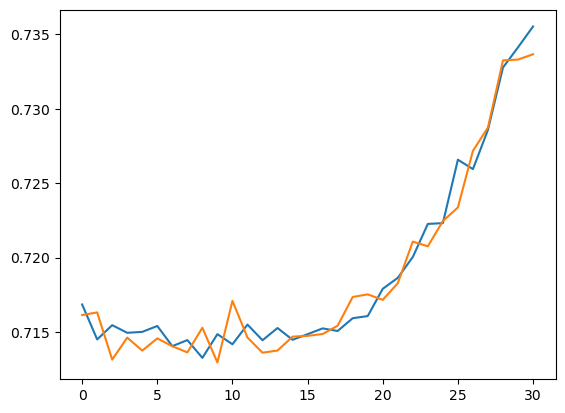

In [74]:
sns.lineplot(res1_)
# sns.lineplot(res2_)
sns.lineplot(res3_)

In [ ]:
def exp2(mode, n, nb=100):
    modeli = list(range(n))
    students = [-1, 100]
    saves = [False]
    pcts = [0]
    
    if mode == 'one':
        teachers = [[(t, nb*2)] for t in [0.01, 0.032, 0.1, 0.316, 1., 3.162, 10.]]
        saves = [True]
    
    elif mode == 'two-A':
        teachers = (
            [[((0.01,0.1,1.,10.), i)] for i in range(4, nb+1, 4)]
            + [[((10.,1.), i//2), ((0.1,0.01), i//2)] for i in range(4, nb+1, 4)]
            + [[(10., i//4), (1., i//4), (0.1, i//4), (0.01, i//4)] for i in range(4, nb+1, 4)]
        )
        
    
    elif mode == 'two-B':
        teachers = [[((10.,1.), i//2), ((0.1,0.01), i//2)] for i in range(10, nb+1, 10)]
        pcts = [0, 0.2, 0.4, 0.6, 0.8, 1]
        
    elif mode.startswith('split'):
        k = int(mode[-1])
        teachers = [[(0.1, i*k), (0.01, i)] for i in range(5, nb//2+1, 5)]
        
    elif mode.startswith('optimal'):
        k = int(mode[-1])
        teachers = []
        for budget in range(10, nb+1, 10):
            for split in range(0, budget+1, 5):
                teachers.append([(0.1, k*split), (0.01, (budget-split))])
        
    # elif mode.startswith('algo'):
    #     k = int(mode[-1])
    #     teachers = [[(0.1, i*k), (0.01, i)] for i in range(1, nb//2+1)]

        
    
    combo = list(product(modeli, students, teachers, saves, pcts))
    # print(combo[::10])
    # print(teachers)
    return process_map(eval_training, *zip(*combo), chunksize=1, ncols=80)

In [19]:
%%time
model2.fit(_X, _Y, batch_size=bs, verbose=0, callbacks=[CustomCallback(), TqdmCallback(verbose=1, ncols=80)], epochs=100) 

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

CPU times: user 11.4 s, sys: 8.69 s, total: 20.1 s
Wall time: 33.8 s


# Results

In [262]:
%%time
df = pd.read_csv('/storage1/fs1/chien-ju.ho/Active/gym/tree4.txt',
                 names=['Student','Teacher','Pct','Exp','Batch','Perf'],
                 sep = ';')
df1 = df.groupby(['Student','Teacher','Pct','Batch','Exp']).Perf.mean().reset_index()
df1 = df1.groupby(['Student','Teacher','Pct','Batch']).Perf.agg(['mean','std','sem','count']).reset_index()
df1 = df1.rename(columns={'mean':'Perf', 'std':'SD', 'sem':'SE'})
df1

CPU times: user 666 ms, sys: 87 ms, total: 753 ms
Wall time: 818 ms


,Student,Teacher,Pct,Batch,Perf,SD,SE,count
0,-1,"[((0.01, 0.032, 0.1, 0.316), 100)]",0.0,100,0.890369,0.031117,0.002541,150
1,-1,"[((0.01, 0.032, 0.1, 0.316), 104)]",0.0,104,0.896051,0.027722,0.002264,150
2,-1,"[((0.01, 0.032, 0.1, 0.316), 108)]",0.0,108,0.902141,0.022414,0.001830,150
3,-1,"[((0.01, 0.032, 0.1, 0.316), 112)]",0.0,112,0.906126,0.022967,0.001875,150
4,-1,"[((0.01, 0.032, 0.1, 0.316), 116)]",0.0,116,0.912892,0.019278,0.001574,150
...,...,...,...,...,...,...,...,...
4713,100,"[(3.162, 200)]",0.0,196,0.735710,0.013935,0.001138,150
4714,100,"[(3.162, 200)]",0.0,197,0.736028,0.014207,0.001160,150
4715,100,"[(3.162, 200)]",0.0,198,0.735700,0.013123,0.001071,150
4716,100,"[(3.162, 200)]",0.0,199,0.737228,0.015899,0.001298,150


In [263]:
subs = {}

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


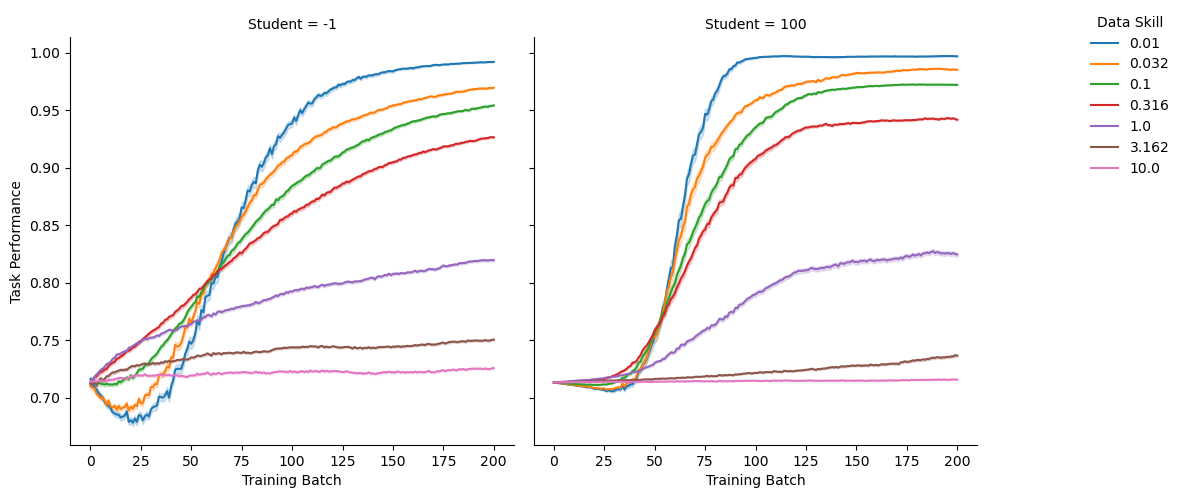

In [264]:
subs['one'] = [str([(i, 200)]) for i in [
    0.010,
    0.032,
    0.100,
    0.316,
    1.000,
    3.162,
    10.000,
]]

df2 = df[df.Teacher.isin(subs['one'])]
# df2 = df2[df2.Student==-1]
df2 = df2[df2.Batch <= 200]
df2['Teacher'] = df2.Teacher.apply(lambda x: str(eval(x)[0][0]))
df2 = df2.sort_values('Teacher', key=lambda x: x.astype(float))
df2 = df2.rename(columns={'Teacher':'Data Skill'})
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.relplot(df2, kind='line', col='Student', x='Batch', y='Perf', hue='Data Skill', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        # title='Performance Improvement by Skill Level in Tree-Search Domain',
        xlabel='Training Batch',
        ylabel='Task Performance'
    )
plt.savefig('images/tree-1.1.pdf', bbox_inches='tight')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


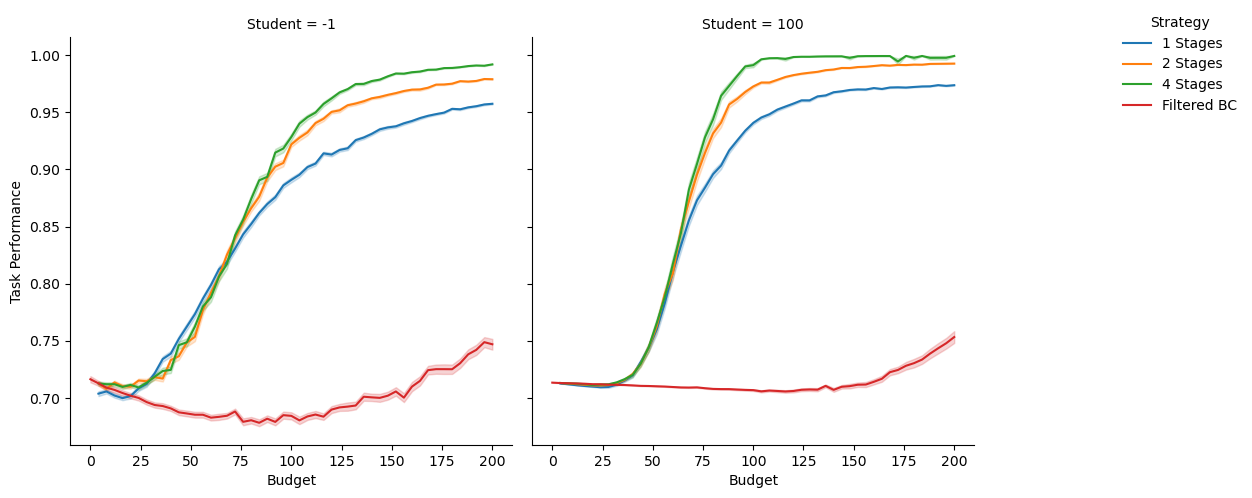

In [285]:
subs['twoA'] = []
# [str([(k, int(v)) for k,v in i]) for i in [
#     [((0.010,0.100,1.000,10.00), nb)],
#     [((10.00,1.000), nb//2), ((0.100,0.010), nb//2)],
#     [(10.00, nb//4), (1.000, nb//4), (0.100, nb//4), (0.010, nb//4)],
# ]]
for nb in range(4,401,4):
    subs['twoA'].append(str([((0.01,0.032,0.1,0.316), nb)]))
    subs['twoA'].append(str([((0.316,0.1), nb//2), ((0.032,0.010), nb//2)]))
    subs['twoA'].append(str([(0.316, nb//4), (0.1, nb//4), (0.032, nb//4), (0.010, nb//4)]))

df2 = df[df.Teacher.isin(subs['twoA'])].copy()

df2 = df2[df2.Pct == 0]
# df2 = df2[df2.Student==100]
df2 = df2[df2.Batch <= 200]

# df2['Teacher'] = df2.Teacher.replace(dict(zip(df2.Teacher.unique(), ['2 Bins', '4 Bins', '1 Bin'])))
df2['Teacher'] = df2.Teacher.apply(lambda x: f"{len(eval(x))} Stages")
df2 = df2.sort_values('Teacher')
                        
                        
df3 = df[df.Teacher==str([(0.01, 200)])].query('Batch <= 50')
df3['Batch'] *= 4
df3['Teacher'] = 'Filtered BC'
df2 = pd.concat([df2, df3])
                        
                        

df2 = df2.rename(columns={'Teacher':'Strategy'})

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.relplot(df2, kind='line', col='Student', x='Batch', y='Perf', hue='Strategy', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        # title='Evaluating Skill-based Curricula by Number of Bins in Tree-Search Domain',
        xlabel='Budget',
        ylabel='Task Performance'
    )
plt.savefig('images/tree-2.1.pdf', bbox_inches='tight')
plt.show()

In [284]:
pd.concat([df2, df3])

,Student,Teacher,Pct,Exp,Batch,Perf
2814,-1,1 Stages,0.0,0,128,0.941993
657780,-1,1 Stages,0.0,6,84,0.858723
657779,-1,1 Stages,0.0,6,80,0.808714
657777,-1,1 Stages,0.0,6,76,0.858891
657775,-1,1 Stages,0.0,6,72,0.843763
...,...,...,...,...,...,...
652825,100,Filtered BC,0.0,149,184,0.722595
652827,100,Filtered BC,0.0,149,188,0.717157
652829,100,Filtered BC,0.0,149,192,0.745849
652831,100,Filtered BC,0.0,149,196,0.752511


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


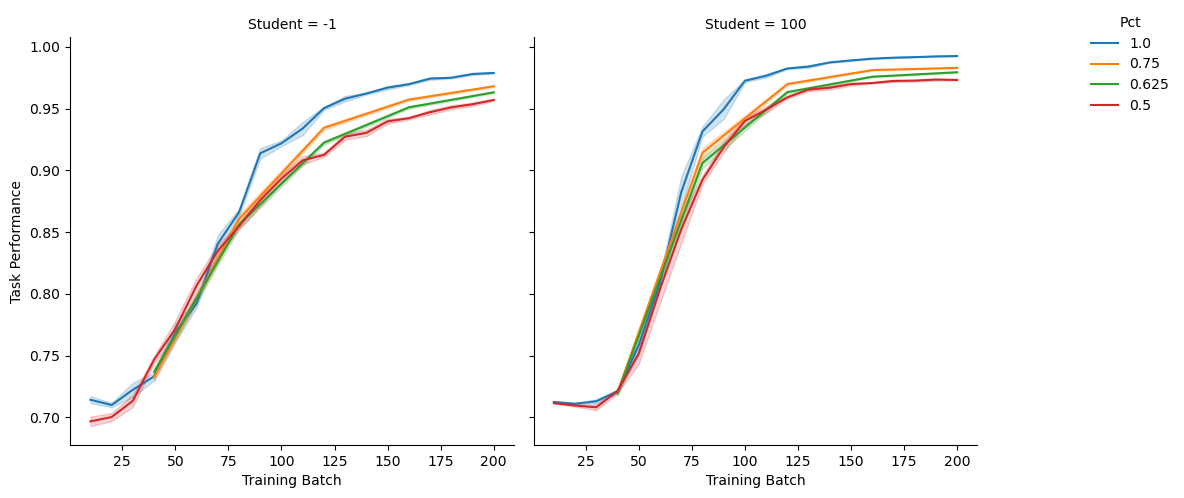

In [287]:
subs['twoB'] = []
for nb in range(10,201,10):
    subs['twoB'].append(str([((0.316,0.1), nb//2), ((0.032,0.010), nb//2)]))

df2 = df[df.Teacher.isin(subs['twoB'])].copy()
# df2 = df2[df2.Student==-1]

# .rename(columns={'Pct':'Classification\nAccuracy'})
df2['Pct'] = 1 - df2['Pct']/2
df2 = df2.astype({'Pct': 'str'})
df2 = df2.sort_values('Pct', ascending=False)
df2 = df2[df2.Pct.isin(['1.0','0.857','0.75','0.625','0.5'])]

# df3 = df[df.Teacher==str([(0.01, 200)])].query('Batch <= 50')
# df3['Batch'] *= 4
# df3['Teacher'] = 'Filtered BC'
# df2 = pd.concat([df2, df3])

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.relplot(df2, kind='line', col='Student', x='Batch', y='Perf', hue='Pct', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        # title='Evaluating Skill-based Curricula by Classification Accuracy in Tree-Search Domain',
        xlabel='Training Batch',
        ylabel='Task Performance'
    )
plt.savefig('images/tree-2.2.pdf', bbox_inches='tight')
plt.show()

In [268]:
def eval_three(k, student):
    df2 = df[df.Student==student]
    
    df2_opt = []
    
    for budget in tqdm(range(10, nb+1, 10), leave=False):
        perfs = []
        for split in range(0, budget+1, 5):
            teacher = str([(0.1, k*split), (0.01, (budget-split))])
            perf = df2[df2.Teacher==teacher].Perf.mean()
            perfs.append((perf, teacher))
        opt = sorted(perfs)[-1]
        df2_opt.append([student, 'optimal', 0, 0, budget, opt[0], eval(opt[1])[0][1]//k])
    df2_opt = pd.DataFrame(df2_opt, columns=['Student','Teacher','Pct','Exp','Batch','Perf','Split'])
    
    df2_algo = []
    algo = [5, 5]
    while np.sum(algo) < 100:
        n0, n2 = algo
        teachers = []
        t0 = str([(0.1, n0*k), (0.1, 5*k), (0.01, n2)])
        t1 = str([(0.1, n0*k), (0.01, n2), (0.01, 5)])

        perf = np.array([df2[df2.Teacher==t0].Perf.mean(), df2[df2.Teacher==t1].Perf.mean()])
        algo[perf.argmax()] += 5
        # print(np.sum(algo), algo)
        df2_algo.append([student, 'algo', 0, 0, np.sum(algo), perf.max(), algo[0]])
    df2_algo = pd.DataFrame(df2_algo, columns=['Student','Teacher','Pct','Exp','Batch','Perf','Split'])
    
    subs[f'three{k}'] = [str([(0.1, i*k), (0.01, i)]) for i in range(5, nb//2+1, 5)]
    df2_1 = df2[df2.Teacher.isin(subs[f'three{k}'])].copy()
    df2_1['Teacher'] = 'split'
    df2_1['Batch'] = df2_1.Batch * 2 / (k+1)
    df2_2 = df2[df2.Teacher == f'[(0.01, {200})]'].copy()
    df2_3 = df2[df2.Teacher == f'[(0.1, {200})]'].copy()
    df2_3['Batch'] = df2_3['Batch'] / k
    df2 = pd.concat([df2_1, df2_2, df2_3, df2_opt, df2_algo])
    df2 = df2[df2.Batch <= 100]
    return df2

In [289]:
%%time
df2 = [eval_three(k, 100) for k in [1,2]]
for k, d in enumerate(df2):
    d.insert(5, 'Cost Ratio', k+1)
df2 = pd.concat(df2)
df2['Teacher'] = df2.Teacher.replace({'split':'50% Low',
                       '[(0.01, 200)]':'0% Low',
                       '[(0.1, 200)]':'100% Low',
                       'optimal':'Optimal',
                       'algo':'Algorithm'})
df2 = df2.sort_values('Teacher')
df2['row'] = df2.Teacher.isin(['50% Low','0% Low','100% Low'])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 18.9 s, sys: 16.5 ms, total: 19 s
Wall time: 18.9 s


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


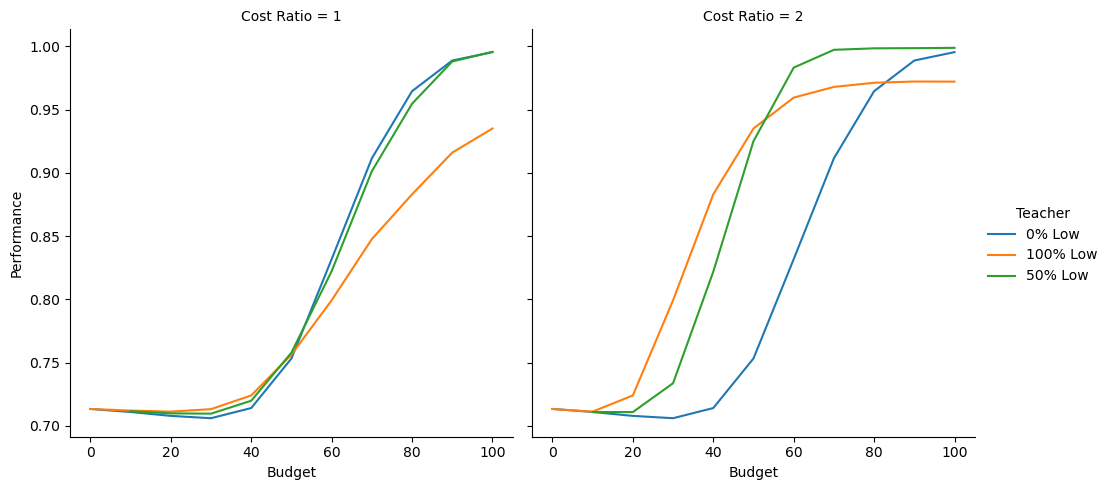

In [290]:
sub = (df2.Batch%10==0) & (df2.row)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    g = sns.relplot(df2[sub], kind='line', x='Batch', y='Perf', hue='Teacher',
                    errorbar=None, col='Cost Ratio')
    # g.fig.suptitle('ONE TITLE FOR ALL')
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    g.set(
        # title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Budget',
        ylabel='Performance'
    )
plt.savefig('images/tree-3.1.pdf', bbox_inches='tight')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


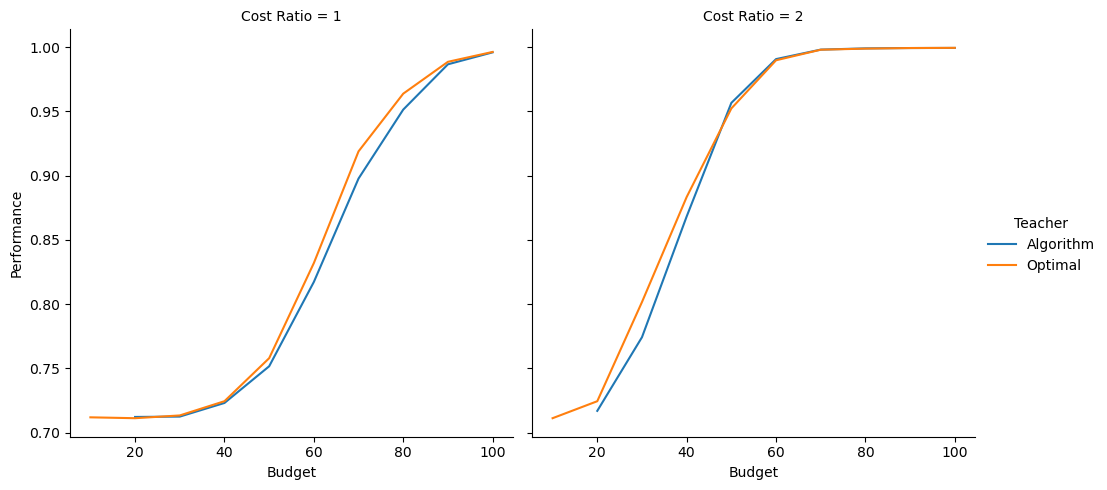

In [291]:
sub = (df2.Batch%10==0) & (~df2.row)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    g = sns.relplot(df2[sub], kind='line', x='Batch', y='Perf', hue='Teacher',
                    errorbar=None, col='Cost Ratio')
    # g.fig.suptitle('ONE TITLE FOR ALL')
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    g.set(
        # title='Performance Improvement in 2x2 Decision Space, Starting from Model100',
        xlabel='Budget',
        ylabel='Performance'
    )
plt.savefig('images/tree-3.2.pdf', bbox_inches='tight')

In [400]:
df2.loc[df2.Teacher=='50% Low', 'Split'] = 50
df2.loc[df2.Teacher=='100% Low', 'Split'] = 100
df2.loc[df2.Teacher=='0% Low', 'Split'] = 0

In [401]:
df3 = df2[(df2.Batch % 10 == 0) & (df2.Batch>=20) & (df2['Cost Ratio']==1)]
df3 = df3.groupby(['Teacher','Batch']).Perf.mean().reset_index()
df3 = df3.pivot(index='Batch',columns='Teacher')
df3.columns=['0','100','50','Algorithm','Optimal']
df3 = df3[['Optimal','Algorithm','0','50','100']]
df3['Optimal'] = df3.max(axis=1)
df3['Algorithm'] = np.where(df3.Algorithm.isna(), df3['50'], df3.Algorithm)

split = df2[(df2['Cost Ratio'] == 1) & (df2.Teacher=='Optimal')].groupby('Batch').Split.mean().astype(int)
df3.insert(1, 'Optimal Split',split.astype(str) + ' - ' + (split.index - split).astype(int).astype(str))

split = df2[(df2['Cost Ratio'] == 1) & (df2.Teacher=='Algorithm')].groupby('Batch').Split.mean().astype(int)
df3.insert(3, 'Algo Split', split.astype(str) + ' - ' + (split.index - split).astype(int).astype(str))
split = (df3.index.astype(int) // 2).astype(str)
df3['Algo Split'] = np.where(df3['Algo Split'].isna(), split + ' - ' + split, df3['Algo Split'])

df3 = df3.rename(columns={'0':'0% Low', '50':'50% Low', '100':'100% Low'})
df3

,Optimal,Optimal Split,Algorithm,Algo Split,0% Low,50% Low,100% Low
Batch,,,,,,,
20.0,0.711014,10 - 10,0.709519,10 - 10,0.708006,0.709519,0.711014
30.0,0.712987,20 - 10,0.711106,20 - 10,0.705504,0.710325,0.712987
40.0,0.724643,30 - 10,0.721727,30 - 10,0.714305,0.718979,0.724643
50.0,0.755797,20 - 30,0.753974,40 - 10,0.748573,0.755682,0.754955
60.0,0.830826,10 - 50,0.816420,40 - 20,0.830826,0.823759,0.802334
70.0,0.916873,10 - 60,0.893054,40 - 30,0.915517,0.899746,0.849990
80.0,0.964088,20 - 60,0.954784,40 - 40,0.964088,0.955266,0.883847
90.0,0.989335,40 - 50,0.986953,50 - 40,0.989335,0.987522,0.914292
100.0,0.996122,40 - 60,0.995844,60 - 40,0.995857,0.995589,0.938225


In [411]:
df3 = df2[(df2.Batch % 10 == 0) & (df2.Batch>=20) & (df2['Cost Ratio']==2)]
df3 = df3.groupby(['Teacher','Batch']).Perf.mean().reset_index()
df3 = df3.pivot(index='Batch',columns='Teacher')
df3.columns=['0','100','50','Algorithm','Optimal']
df3 = df3[['Optimal','Algorithm','0','50','100']]
# df3['Optimal'] = df3.max(axis=1)
df3['Algorithm'] = np.where(df3.Algorithm.isna(), df3['50'], df3.Algorithm)

split = df2[(df2['Cost Ratio'] == 2) & (df2.Teacher=='Optimal')].groupby('Batch').Split.mean().astype(int)
df3.insert(1, 'Optimal Split',split.astype(str) + ' - ' + (split.index - split).astype(int).astype(str))

split = df2[(df2['Cost Ratio'] == 2) & (df2.Teacher=='Algorithm')].groupby('Batch').Split.mean().astype(int)
df3.insert(3, 'Algo Split', split.astype(str) + ' - ' + (split.index - split).astype(int).astype(str))
split = (df3.index.astype(int) // 2).astype(str)
df3['Algo Split'] = np.where(df3['Algo Split'].isna(), split + ' - ' + split, df3['Algo Split'])

df3 = df3.rename(columns={'0':'0% Low', '50':'50% Low', '100':'100% Low'})
df3

,Optimal,Optimal Split,Algorithm,Algo Split,0% Low,50% Low,100% Low
Batch,,,,,,,
20.0,0.710511,10 - 10,0.710511,10 - 10,0.708006,0.710511,0.724643
30.0,0.753095,20 - 10,0.754400,20 - 10,0.705504,0.735443,0.802334
40.0,0.869896,30 - 10,0.874786,30 - 10,0.714305,0.818632,0.883847
50.0,0.943429,30 - 20,0.943816,40 - 10,0.748573,0.921032,0.938225
60.0,0.990333,40 - 20,0.990944,40 - 20,0.830826,0.983547,0.960150
70.0,0.997814,40 - 30,0.997890,40 - 30,0.915517,0.997155,0.969273
80.0,0.999042,50 - 30,0.998947,50 - 30,0.964088,0.998614,0.971186
90.0,0.999267,60 - 30,0.999300,60 - 30,0.989335,0.998808,0.972636
100.0,0.999450,70 - 30,0.999474,70 - 30,0.995857,0.998948,0.973244


In [409]:
df3 = df2[(df2.Batch % 10 == 0) & (df2.Batch>=20) & (df2['Cost Ratio']==2)]


In [410]:
df3[df3.Teacher=='Optimal'].sort_values('Batch')

,Student,Teacher,Pct,Exp,Batch,Cost Ratio,Perf,Split
0,100,Optimal,0.0,0,20.0,2,0.710511,10.0
1,100,Optimal,0.0,0,30.0,2,0.753095,20.0
2,100,Optimal,0.0,0,40.0,2,0.869896,30.0
3,100,Optimal,0.0,0,50.0,2,0.943429,30.0
4,100,Optimal,0.0,0,60.0,2,0.990333,40.0
5,100,Optimal,0.0,0,70.0,2,0.997814,40.0
6,100,Optimal,0.0,0,80.0,2,0.999042,50.0
7,100,Optimal,0.0,0,90.0,2,0.999267,60.0
8,100,Optimal,0.0,0,100.0,2,0.999450,70.0


In [336]:
df3 = df2[(df2.Batch % 10 == 0) & (df2.Batch>=20) & (df2['Cost Ratio']==2)]
df3 = df3.groupby(['Teacher','Batch']).Perf.mean().reset_index()
df3 = df3.pivot(index='Batch',columns='Teacher')
df3.columns=['0','100','50','Algorithm','Optimal']
df3 = df3[['Optimal','Algorithm','0','50','100']]
df3['Optimal'] = df3.max(axis=1)
df3['Algorithm'] = np.where(df3.Algorithm.isna(), df3['50'], df3.Algorithm)
df3

,Optimal,Algorithm,0,50,100
Batch,,,,,
20.0,0.724643,0.710511,0.708006,0.710511,0.724643
30.0,0.802334,0.754400,0.705504,0.735443,0.802334
40.0,0.883847,0.874786,0.714305,0.818632,0.883847
50.0,0.943816,0.943816,0.748573,0.921032,0.938225
60.0,0.990944,0.990944,0.830826,0.983547,0.960150
70.0,0.997890,0.997890,0.915517,0.997155,0.969273
80.0,0.999042,0.998947,0.964088,0.998614,0.971186
90.0,0.999300,0.999300,0.989335,0.998808,0.972636
100.0,0.999474,0.999474,0.995857,0.998948,0.973244


In [421]:
teachers = [0.01, 0.032, 0.1, 0.316, 1., 3.162, 10.]
students = [-1, 10]
modeli = list(range(20))
saves = [False]
pcts = [0]


In [422]:
from itertools import product

In [437]:
combo = list(product(teachers, students, modeli, saves, pcts))

# 2x10

In [369]:
n = 500

  0%|          | 0/3500 [00:00<?, ?it/s]

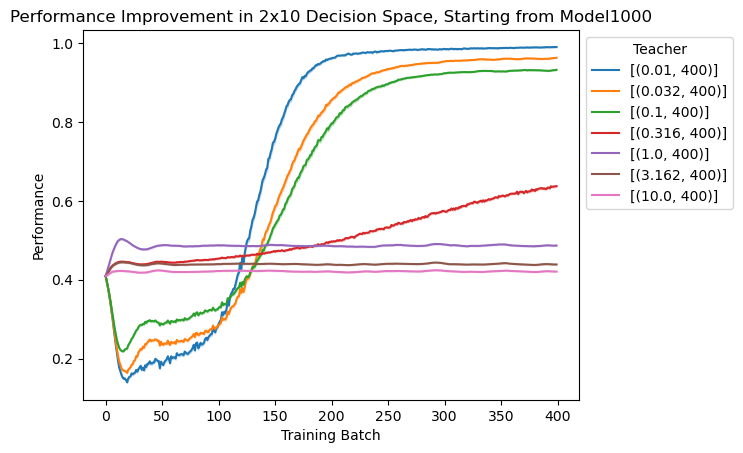

In [370]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='one')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model1000',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/2000 [00:00<?, ?it/s]

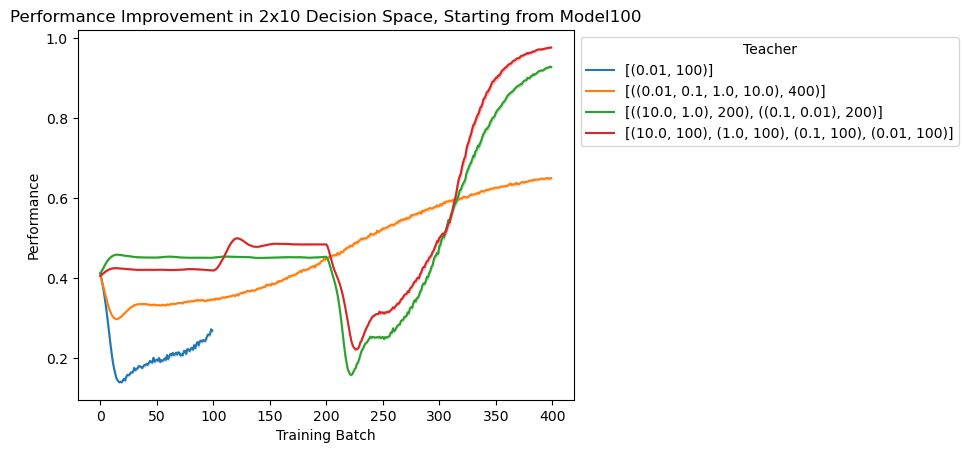

In [371]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='two')

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Batch',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

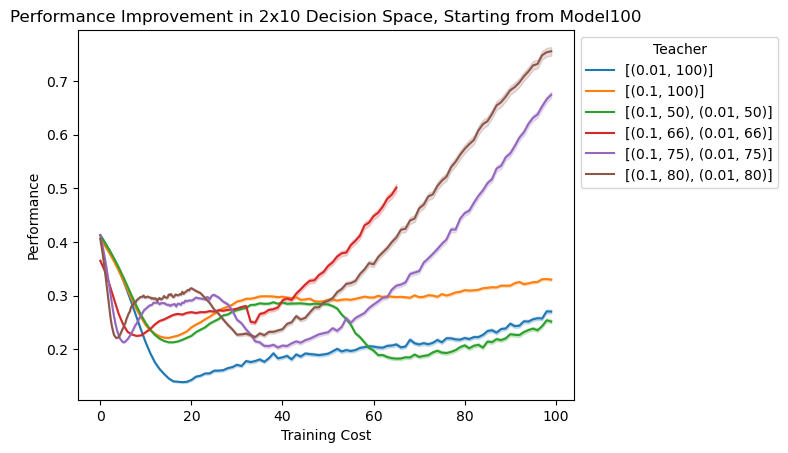

In [372]:
df, df2 = analyze(student=100, n=n, num_batches=100, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

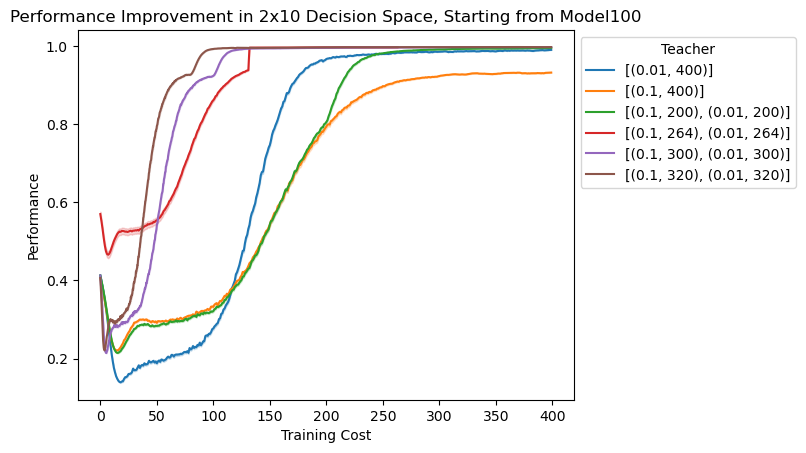

In [373]:
df, df2 = analyze(student=100, n=n, num_batches=400, mode='three')

df = df[~df.Perf.isna()]
df['Batch2'] = df.apply(adjust, axis=1)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ax = sns.lineplot(df, x='Batch2', y='Perf', hue='Teacher', errorbar='se')
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set(
        title='Performance Improvement in 2x10 Decision Space, Starting from Model100',
        xlabel='Training Cost',
        ylabel='Performance'
    )